In [1]:
!pip install torchmetrics

In [2]:
import pandas as pd
import numpy as np
import re
import random
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1, recall, accuracy
import gensim
from gensim.models import FastText

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
stopwords = stopwords.words('english')

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available()\
                              else torch.device('cpu')
DEVICE

device(type='cuda')

# Data preprocessing

In [5]:
df = pd.read_csv('../input/datasetnnmethods/Fake.csv').drop_duplicates().reset_index(drop=True)
df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23473,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23474,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23475,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23476,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


Необходимо почистить тексты, привести все к числовому виду.
Можно посмотрет на сами классы по количественным показателям, например.

<AxesSubplot:>

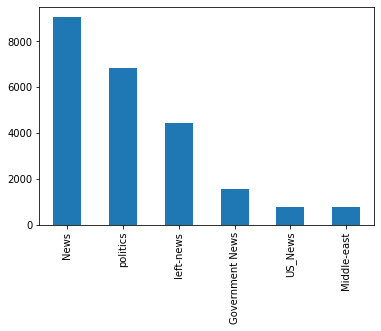

In [6]:
df['subject'].value_counts().plot.bar()

Видно, что количество данных по тем или иным классам очень сильно отличается, что может плохо повлиять на обучение.

In [7]:
def preprocessing(text):
    clean_text = []
    text = text.lower()
    text = word_tokenize(text)
    for word in text:
        if word not in stopwords:
            clean_text.append(word)
    return clean_text

In [8]:
df['clean_text'] = df['text'].apply(preprocessing)
df['category'] = df['subject'].astype('category').cat.codes
df

,title,text,subject,date,clean_text,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, wish, americans, happy, new, y...",2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[friday, ,, revealed, former, milwaukee, sheri...",2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[christmas, day, ,, donald, trump, announced, ...",2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, annual, christmas, day, ...",2
...,...,...,...,...,...,...
23473,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016","[21st, century, wire, says, 21wire, reported, ...",1
23474,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016","[21st, century, wire, says, familiar, theme, ....",1
23475,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016","[patrick, henningsen, 21st, century, wireremem...",1
23476,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016","[21st, century, wire, says, al, jazeera, ameri...",1


In [9]:
data = df[['clean_text', 'category']]
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True)

In [10]:
data

,clean_text,category
0,"[donald, trump, wish, americans, happy, new, y...",2
1,"[house, intelligence, committee, chairman, dev...",2
2,"[friday, ,, revealed, former, milwaukee, sheri...",2
3,"[christmas, day, ,, donald, trump, announced, ...",2
4,"[pope, francis, used, annual, christmas, day, ...",2
...,...,...
23473,"[21st, century, wire, says, 21wire, reported, ...",1
23474,"[21st, century, wire, says, familiar, theme, ....",1
23475,"[patrick, henningsen, 21st, century, wireremem...",1
23476,"[21st, century, wire, says, al, jazeera, ameri...",1


In [11]:
vocab = Counter()
for line in tqdm(data['clean_text']):
    vocab.update(line)

100%|██████████| 23478/23478 [00:01<00:00, 22711.12it/s]


In [12]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 59487


In [13]:
word2id = {'UNK':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

Самое длинное предложение

In [14]:
MAX_SENT = len(max(df['text'].tolist()))
MAX_SENT

1150

Слишком много, не хватает памяти на гпу :(

In [15]:
MAX_SENT = 524

In [16]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-29 17:21:15--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.198.32
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.198.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  57.8MB/s    in 26s     

2021-12-29 17:21:42 (59.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [17]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

Приписываем веса неизвестным словам в соответствии во статьей.

In [18]:
weights = np.zeros((len(word2id), 300))

unknown_word = 0
for word, i in word2id.items():
    try:
        weights[i] = word2vec[word]
    except KeyError:
        unknown_word += 1
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

weights = torch.FloatTensor(weights)

# Train&Val Dataset

In [19]:
class Dataset(Dataset):
    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.target = dataset['category'].values
        
        self.length = dataset.shape[0]
        self.word2id = word2id
        self.device = DEVICE


    def __len__(self):
        return self.length
    

    def __getitem__(self, index): 
        tokens = self.dataset[index]
        token_ids = []
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id else self.word2id['UNK'] for token in tokens][:MAX_SENT])
        y = [self.target[index]]
        return ids, y
    

    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        padded_ids = torch.LongTensor(torch.stack([F.pad(idx, (1, MAX_SENT - len(idx))) for idx in ids], dim=0)).to(self.device)
        y = torch.LongTensor(y).view(len(y)).to(self.device)
        return padded_ids, y

In [20]:
train_dataset = Dataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [21]:
val_dataset = Dataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=128)

# Model

In [22]:
class CNN_LSTM(nn.Module):
    def __init__(self, weights, vocab_size, max_len, filter_sizes, drop_start):
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.max_len = max_len
        self.filter_sizes = filter_sizes
        self.max_filter = self.max_len - max(self.filter_sizes) + 1
        self.vocab_size = vocab_size      
        self.drop_start = drop_start
        
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=4)
        
        self.conv_layers = {2: self.conv2, 
                            3: self.conv3, 
                            4: self.conv4}
        
        self.lstm = nn.LSTM(input_size=150, hidden_size=150, num_layers=1, batch_first=True)

        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)
        self.linear = nn.Linear(150, 6)
    
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1, 2)
        if self.drop_start:
            embedded = self.dropout(embedded)
            
        cnn_outputs = []
        for filter_size in self.filter_sizes:
            layer = self.conv_layers[filter_size]
            layer = layer(embedded)
            hidden = self.relu(layer)
            hidden = hidden[:, :, :self.max_filter]
            cnn_outputs.append(hidden)
            
        if len(self.filter_sizes) > 1:
            rnn_inputs = torch.cat(cnn_outputs, -1)
        else:
            rnn_inputs = hidden
            
        _, (hidden_state, _) = self.lstm(rnn_inputs.transpose(1, 2))
        if self.drop_start:
            embedded = self.dropout(embedded)
        logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        
        return logits 

# Train&Validation

In [23]:
def train(model, iterator, optimizer, criterion, metric, n_epoch):
    progress_bar = tqdm(total=len(train_iterator.dataset),
                        desc='Epoch {}'.format(n_epoch + 1))
    epoch_loss = []  
    epoch_metric = []
    model.train()
    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        batch_metric = metric(preds.argmax(1).long(), ys.long(),
                              average='weighted', num_classes=6,
                              ignore_index=0)
        epoch_metric.append(batch_metric.cpu().numpy())
        progress_bar.update(texts.shape[0])
    progress_bar.close()
    return epoch_loss, epoch_metric

In [24]:
def evaluate(model, iterator, criterion, metric):
    epoch_loss = []
    epoch_metric = []
    model.eval()
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), ys.long(),
                                  average='weighted', num_classes=6,
                                  ignore_index=0)

            epoch_metric.append(batch_metric.cpu().numpy())
        
    return  epoch_loss, epoch_metric

In [25]:
def training(model, train_iterator, val_iterator, optimizer, criterion, metric, epochs):
    train_loss = []
    train_metric = []
    val_loss = []
    val_metric = []

    for n in range(epochs):
        print('\nTraining')
        loss, score = train(model, train_iterator, optimizer, criterion, metric, n)
        train_loss.extend(loss)
        train_metric.extend(score)
        if int(epochs) % 3 == 0:
            print('\nTrain loss:', np.mean(train_loss), '\nTrain accuracy:', np.mean(train_metric))
        
        print('\nValidation')
        loss, score = evaluate(model, val_iterator,criterion, metric)
        val_loss.extend(loss)
        val_metric.extend(score)
        if int(epochs) % 3 == 0:
            print('\nValidation loss:', np.mean(val_loss), '\nValidation accuracy:', np.mean(val_metric))

    return train_loss, val_loss, train_metric, val_metric

In [26]:
model = CNN_LSTM(weights, vocab_size=len(word2id), max_len=MAX_SENT, filter_sizes=[2], drop_start=0)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()


In [27]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
EPOCHS = 6

In [29]:
train_loss, val_loss, train_metric, val_metric = training(model, train_iterator, val_iterator, optimizer, criterion, accuracy, EPOCHS)


Training


Epoch 1: 100%|██████████| 18782/18782 [00:18<00:00, 1024.25it/s]



Train loss: 1.6379467897674664 
Train accuracy: 0.41914248

Validation

Validation loss: 1.6344611000370335 
Validation accuracy: 0.4238352

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1523.39it/s]



Train loss: 1.636246334938776 
Train accuracy: 0.42138967

Validation

Validation loss: 1.634518642683287 
Validation accuracy: 0.4232263

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1560.06it/s]



Train loss: 1.6350110490846526 
Train accuracy: 0.423278

Validation

Validation loss: 1.638276733793654 
Validation accuracy: 0.418445

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1526.74it/s]



Train loss: 1.634936030827412 
Train accuracy: 0.42322806

Validation

Validation loss: 1.6371481926054567 
Validation accuracy: 0.4196594

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1554.00it/s]



Train loss: 1.6345273434710341 
Train accuracy: 0.42390937

Validation

Validation loss: 1.6365299199078533 
Validation accuracy: 0.4207602

Training


Epoch 6: 100%|██████████| 18782/18782 [00:12<00:00, 1547.13it/s]



Train loss: 1.6308132654685281 
Train accuracy: 0.42936406

Validation

Validation loss: 1.6046636485838675 
Validation accuracy: 0.46484354


Результаты плохие: loss большой, accuracy маленькая.

Попробуем поиграться с параметрами.

# Эксперименты

In [30]:
results = []
filter_sizes = [[2], [3], [4], [2, 3], [2, 4], [3, 4], [2, 3, 4]]

for drop_start in [0, 1]:
    for size in filter_sizes:
        print('Params: ')
        print('drop_start=', drop_start, '\nfilters=', size)
        
        model = CNN_LSTM(weights=weights, 
                         vocab_size=len(word2id), 
                         max_len=MAX_SENT, 
                         filter_sizes=size, 
                         drop_start=drop_start)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)

        train_loss, val_loss, train_metric, val_metric = training(
            model, train_iterator, val_iterator, optimizer, criterion, accuracy, EPOCHS)

        results.append({
            'drop_start': drop_start,
            'filter_size': size,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metric': train_metric,
            'val_metric': val_metric})

Params: 
drop_start= 0 
filters= [2]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1564.56it/s]



Train loss: 1.6390108494531541 
Train accuracy: 0.41864622

Validation

Validation loss: 1.6357497073508598 
Validation accuracy: 0.4229327

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1558.69it/s]



Train loss: 1.6361099469418428 
Train accuracy: 0.4221335

Validation

Validation loss: 1.639806694275624 
Validation accuracy: 0.41590756

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1536.18it/s]



Train loss: 1.636523326778628 
Train accuracy: 0.42117488

Validation

Validation loss: 1.6385240758861508 
Validation accuracy: 0.41761103

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1562.75it/s]



Train loss: 1.6360614506565794 
Train accuracy: 0.4221092

Validation

Validation loss: 1.637755008968147 
Validation accuracy: 0.418751

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1552.55it/s]



Train loss: 1.6356462392677256 
Train accuracy: 0.42258433

Validation

Validation loss: 1.6371578242327716 
Validation accuracy: 0.4194796

Training


Epoch 6: 100%|██████████| 18782/18782 [00:11<00:00, 1568.19it/s]



Train loss: 1.6351257962704786 
Train accuracy: 0.42328855

Validation

Validation loss: 1.636367723211512 
Validation accuracy: 0.4206172
Params: 
drop_start= 0 
filters= [3]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1522.62it/s]



Train loss: 1.6386841357159776 
Train accuracy: 0.41891122

Validation

Validation loss: 1.6354722686716028 
Validation accuracy: 0.42268676

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1513.99it/s]



Train loss: 1.6374071041742961 
Train accuracy: 0.420362

Validation

Validation loss: 1.637239886296762 
Validation accuracy: 0.42603123

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1526.60it/s]



Train loss: 1.6232099257358887 
Train accuracy: 0.4442247

Validation

Validation loss: 1.5725949659003868 
Validation accuracy: 0.5146273

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1506.28it/s]



Train loss: 1.5663862376391482 
Train accuracy: 0.5085792

Validation

Validation loss: 1.5264043944912988 
Validation accuracy: 0.5606833

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1520.38it/s]



Train loss: 1.5348105756603942 
Train accuracy: 0.5428541

Validation

Validation loss: 1.4978324277980908 
Validation accuracy: 0.5888971

Training


Epoch 6: 100%|██████████| 18782/18782 [00:12<00:00, 1534.67it/s]



Train loss: 1.5093798295440588 
Train accuracy: 0.57017016

Validation

Validation loss: 1.4790619842640989 
Validation accuracy: 0.60738915
Params: 
drop_start= 0 
filters= [4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1510.11it/s]



Train loss: 1.6378570795059204 
Train accuracy: 0.42020452

Validation

Validation loss: 1.6337666157129649 
Validation accuracy: 0.42541942

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1509.63it/s]



Train loss: 1.6349750668013177 
Train accuracy: 0.4239313

Validation

Validation loss: 1.6330894280124355 
Validation accuracy: 0.42608747

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1488.67it/s]



Train loss: 1.634133485709729 
Train accuracy: 0.42487472

Validation

Validation loss: 1.666465106311145 
Validation accuracy: 0.38748413

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1522.08it/s]



Train loss: 1.580245857944294 
Train accuracy: 0.4866526

Validation

Validation loss: 1.6038489800852698 
Validation accuracy: 0.4572453

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1497.29it/s]



Train loss: 1.5459950646575615 
Train accuracy: 0.5247425

Validation

Validation loss: 1.5651764334859075 
Validation accuracy: 0.5002023

Training


Epoch 6: 100%|██████████| 18782/18782 [00:12<00:00, 1523.96it/s]



Train loss: 1.5295069774532535 
Train accuracy: 0.5452737

Validation

Validation loss: 1.5382359425226848 
Validation accuracy: 0.5330457
Params: 
drop_start= 0 
filters= [2, 3]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:20<00:00, 897.09it/s]



Train loss: 1.6367427597240525 
Train accuracy: 0.4193412

Validation

Validation loss: 1.636216872447246 
Validation accuracy: 0.42405957

Training


Epoch 2: 100%|██████████| 18782/18782 [00:20<00:00, 901.65it/s]



Train loss: 1.635630724786901 
Train accuracy: 0.42173824

Validation

Validation loss: 1.633476958081529 
Validation accuracy: 0.42597288

Training


Epoch 3: 100%|██████████| 18782/18782 [00:20<00:00, 896.95it/s]



Train loss: 1.637034616232459 
Train accuracy: 0.4203211

Validation

Validation loss: 1.6339548010009903 
Validation accuracy: 0.42495808

Training


Epoch 4: 100%|██████████| 18782/18782 [00:20<00:00, 898.11it/s]



Train loss: 1.6266533892576387 
Train accuracy: 0.4366331

Validation

Validation loss: 1.5755616845311344 
Validation accuracy: 0.49258375

Training


Epoch 5: 100%|██████████| 18782/18782 [00:20<00:00, 896.37it/s]



Train loss: 1.5818196363189594 
Train accuracy: 0.48649096

Validation

Validation loss: 1.5385663528700133 
Validation accuracy: 0.53307205

Training


Epoch 6: 100%|██████████| 18782/18782 [00:20<00:00, 899.25it/s]



Train loss: 1.5686486298535145 
Train accuracy: 0.50152636

Validation

Validation loss: 1.5515416763924263 
Validation accuracy: 0.51485205
Params: 
drop_start= 0 
filters= [2, 4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:20<00:00, 894.71it/s]



Train loss: 1.638265072893934 
Train accuracy: 0.42260492

Validation

Validation loss: 1.6346878071089048 
Validation accuracy: 0.42450553

Training


Epoch 2: 100%|██████████| 18782/18782 [00:21<00:00, 894.22it/s]



Train loss: 1.6359502717751224 
Train accuracy: 0.42365777

Validation

Validation loss: 1.6341253776808042 
Validation accuracy: 0.4242885

Training


Epoch 3: 100%|██████████| 18782/18782 [00:20<00:00, 895.98it/s]



Train loss: 1.6349789834076585 
Train accuracy: 0.4235049

Validation

Validation loss: 1.6328663965603252 
Validation accuracy: 0.42368212

Training


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 892.11it/s]



Train loss: 1.6140448669998013 
Train accuracy: 0.45278594

Validation

Validation loss: 1.5781419615487795 
Validation accuracy: 0.49213934

Training


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 894.09it/s]



Train loss: 1.5730469186289782 
Train accuracy: 0.49793893

Validation

Validation loss: 1.5410395074535062 
Validation accuracy: 0.53307325

Training


Epoch 6: 100%|██████████| 18782/18782 [00:20<00:00, 895.35it/s]



Train loss: 1.5458621142132212 
Train accuracy: 0.5281779

Validation

Validation loss: 1.515461930283555 
Validation accuracy: 0.56062967
Params: 
drop_start= 0 
filters= [3, 4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:21<00:00, 881.96it/s]



Train loss: 1.6374397221065702 
Train accuracy: 0.4208584

Validation

Validation loss: 1.6338825999079525 
Validation accuracy: 0.4249825

Training


Epoch 2: 100%|██████████| 18782/18782 [00:21<00:00, 883.60it/s]



Train loss: 1.6347689482630516 
Train accuracy: 0.42404374

Validation

Validation loss: 1.6322976962940112 
Validation accuracy: 0.4263275

Training


Epoch 3: 100%|██████████| 18782/18782 [00:21<00:00, 884.60it/s]



Train loss: 1.6327013169286473 
Train accuracy: 0.42641714

Validation

Validation loss: 1.6076113103746295 
Validation accuracy: 0.51407695

Training


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 877.71it/s]



Train loss: 1.5822667957974128 
Train accuracy: 0.4899323

Validation

Validation loss: 1.5530603705225765 
Validation accuracy: 0.5596987

Training


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 884.20it/s]



Train loss: 1.5427914961665665 
Train accuracy: 0.53277165

Validation

Validation loss: 1.5200750164083532 
Validation accuracy: 0.5871226

Training


Epoch 6: 100%|██████████| 18782/18782 [00:21<00:00, 880.40it/s]



Train loss: 1.5165608679356217 
Train accuracy: 0.56112593

Validation

Validation loss: 1.4978690501805898 
Validation accuracy: 0.60559
Params: 
drop_start= 0 
filters= [2, 3, 4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:29<00:00, 634.36it/s]



Train loss: 1.6367197101618969 
Train accuracy: 0.42401364

Validation

Validation loss: 1.6348545390206415 
Validation accuracy: 0.4239692

Training


Epoch 2: 100%|██████████| 18782/18782 [00:29<00:00, 634.13it/s]



Train loss: 1.63060965505587 
Train accuracy: 0.433363

Validation

Validation loss: 1.6113712594315812 
Validation accuracy: 0.47000113

Training


Epoch 3: 100%|██████████| 18782/18782 [00:29<00:00, 634.60it/s]



Train loss: 1.5904283447871133 
Train accuracy: 0.48797864

Validation

Validation loss: 1.5409014192787376 
Validation accuracy: 0.543483

Training


Epoch 4: 100%|██████████| 18782/18782 [00:29<00:00, 634.75it/s]



Train loss: 1.5405791211290425 
Train accuracy: 0.5409281

Validation

Validation loss: 1.5030926216293026 
Validation accuracy: 0.581591

Training


Epoch 5: 100%|██████████| 18782/18782 [00:29<00:00, 635.21it/s]



Train loss: 1.5147985435667493 
Train accuracy: 0.5679923

Validation

Validation loss: 1.4796638553206984 
Validation accuracy: 0.60528135

Training


Epoch 6: 100%|██████████| 18782/18782 [00:29<00:00, 635.78it/s]



Train loss: 1.4936861775629644 
Train accuracy: 0.5901409

Validation

Validation loss: 1.4645371904244293 
Validation accuracy: 0.6204996
Params: 
drop_start= 1 
filters= [2]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1553.88it/s]



Train loss: 1.6375285030222264 
Train accuracy: 0.4216289

Validation

Validation loss: 1.6353069221651233 
Validation accuracy: 0.42261934

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1555.76it/s]



Train loss: 1.6360781509049085 
Train accuracy: 0.4225656

Validation

Validation loss: 1.6346197547139347 
Validation accuracy: 0.42400125

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1541.39it/s]



Train loss: 1.635009471521356 
Train accuracy: 0.42385668

Validation

Validation loss: 1.6339499553044636 
Validation accuracy: 0.42453697

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1541.89it/s]



Train loss: 1.6341639300998376 
Train accuracy: 0.424813

Validation

Validation loss: 1.6368506542734198 
Validation accuracy: 0.42223352

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1531.21it/s]



Train loss: 1.6341882564583603 
Train accuracy: 0.42418528

Validation

Validation loss: 1.6362362101271346 
Validation accuracy: 0.42264017

Training


Epoch 6: 100%|██████████| 18782/18782 [00:12<00:00, 1545.81it/s]



Train loss: 1.6333430291844062 
Train accuracy: 0.4240056

Validation

Validation loss: 1.6270980920877542 
Validation accuracy: 0.46690226
Params: 
drop_start= 1 
filters= [3]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1526.77it/s]



Train loss: 1.6383523357157805 
Train accuracy: 0.42090923

Validation

Validation loss: 1.6338087159234125 
Validation accuracy: 0.42405313

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1515.50it/s]



Train loss: 1.6369630929564132 
Train accuracy: 0.42107853

Validation

Validation loss: 1.6355249704541386 
Validation accuracy: 0.4231513

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1528.05it/s]



Train loss: 1.6359830827129132 
Train accuracy: 0.4221987

Validation

Validation loss: 1.6358897922275302 
Validation accuracy: 0.42247835

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1507.53it/s]



Train loss: 1.6187250352635676 
Train accuracy: 0.44499353

Validation

Validation loss: 1.5746209403953038 
Validation accuracy: 0.4907272

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1521.21it/s]



Train loss: 1.5802068934148672 
Train accuracy: 0.4885665

Validation

Validation loss: 1.5381439531171643 
Validation accuracy: 0.53126866

Training


Epoch 6: 100%|██████████| 18782/18782 [00:12<00:00, 1519.11it/s]



Train loss: 1.5502976362937702 
Train accuracy: 0.5215853

Validation

Validation loss: 1.512861118660317 
Validation accuracy: 0.5593246
Params: 
drop_start= 1 
filters= [4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:12<00:00, 1502.37it/s]



Train loss: 1.6386830977031164 
Train accuracy: 0.41936946

Validation

Validation loss: 1.632617557370985 
Validation accuracy: 0.42630705

Training


Epoch 2: 100%|██████████| 18782/18782 [00:12<00:00, 1494.91it/s]



Train loss: 1.6358514837667244 
Train accuracy: 0.42244577

Validation

Validation loss: 1.6331562254879926 
Validation accuracy: 0.4248039

Training


Epoch 3: 100%|██████████| 18782/18782 [00:12<00:00, 1491.58it/s]



Train loss: 1.6344106024355034 
Train accuracy: 0.4240755

Validation

Validation loss: 1.633232105959643 
Validation accuracy: 0.42493457

Training


Epoch 4: 100%|██████████| 18782/18782 [00:12<00:00, 1496.49it/s]



Train loss: 1.6343562205632527 
Train accuracy: 0.42404222

Validation

Validation loss: 1.6350374455387529 
Validation accuracy: 0.42092153

Training


Epoch 5: 100%|██████████| 18782/18782 [00:12<00:00, 1485.62it/s]



Train loss: 1.6340725365139188 
Train accuracy: 0.42437005

Validation

Validation loss: 1.6344664322363365 
Validation accuracy: 0.42195502

Training


Epoch 6: 100%|██████████| 18782/18782 [00:12<00:00, 1463.30it/s]



Train loss: 1.6336780410775251 
Train accuracy: 0.42478472

Validation

Validation loss: 1.6342058353595905 
Validation accuracy: 0.42249283
Params: 
drop_start= 1 
filters= [2, 3]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:20<00:00, 896.28it/s]



Train loss: 1.6367852079625032 
Train accuracy: 0.42162776

Validation

Validation loss: 1.6346764435639252 
Validation accuracy: 0.42405

Training


Epoch 2: 100%|██████████| 18782/18782 [00:20<00:00, 896.13it/s]



Train loss: 1.635117462297686 
Train accuracy: 0.42347825

Validation

Validation loss: 1.6338634184888892 
Validation accuracy: 0.42406562

Training


Epoch 3: 100%|██████████| 18782/18782 [00:20<00:00, 897.03it/s]



Train loss: 1.634096086430712 
Train accuracy: 0.42465723

Validation

Validation loss: 1.6335433463792544 
Validation accuracy: 0.42418802

Training


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 893.37it/s]



Train loss: 1.6333937229347877 
Train accuracy: 0.42570785

Validation

Validation loss: 1.6329085045569651 
Validation accuracy: 0.42477816

Training


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 893.29it/s]



Train loss: 1.6328487323254954 
Train accuracy: 0.42626876

Validation

Validation loss: 1.632329663714847 
Validation accuracy: 0.42549103

Training


Epoch 6: 100%|██████████| 18782/18782 [00:20<00:00, 894.71it/s]



Train loss: 1.6326221604736484 
Train accuracy: 0.42621255

Validation

Validation loss: 1.632601600509506 
Validation accuracy: 0.42508876
Params: 
drop_start= 1 
filters= [2, 4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:21<00:00, 890.41it/s]



Train loss: 1.6380599096518795 
Train accuracy: 0.41985372

Validation

Validation loss: 1.6351661617691453 
Validation accuracy: 0.42249334

Training


Epoch 2: 100%|██████████| 18782/18782 [00:21<00:00, 889.15it/s]



Train loss: 1.6354794283302463 
Train accuracy: 0.42323774

Validation

Validation loss: 1.6343009858518034 
Validation accuracy: 0.42292878

Training


Epoch 3: 100%|██████████| 18782/18782 [00:21<00:00, 890.33it/s]



Train loss: 1.614012661704671 
Train accuracy: 0.45445406

Validation

Validation loss: 1.558878156515929 
Validation accuracy: 0.5139319

Training


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 887.50it/s]



Train loss: 1.5664127404187 
Train accuracy: 0.5066835

Validation

Validation loss: 1.5799107680449616 
Validation accuracy: 0.49231175

Training


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 887.66it/s]



Train loss: 1.5467032516894696 
Train accuracy: 0.52811253

Validation

Validation loss: 1.542130015347455 
Validation accuracy: 0.5325353

Training


Epoch 6: 100%|██████████| 18782/18782 [00:21<00:00, 890.71it/s]



Train loss: 1.5420038082432044 
Train accuracy: 0.53358054

Validation

Validation loss: 1.5179569672893833 
Validation accuracy: 0.55819064
Params: 
drop_start= 1 
filters= [3, 4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:21<00:00, 878.05it/s]



Train loss: 1.636881140624585 
Train accuracy: 0.42152795

Validation

Validation loss: 1.6345058002987423 
Validation accuracy: 0.4234046

Training


Epoch 2: 100%|██████████| 18782/18782 [00:21<00:00, 878.11it/s]



Train loss: 1.6348120030902682 
Train accuracy: 0.423911

Validation

Validation loss: 1.6334509156845711 
Validation accuracy: 0.42542252

Training


Epoch 3: 100%|██████████| 18782/18782 [00:21<00:00, 879.10it/s]



Train loss: 1.633975309038919 
Train accuracy: 0.42441157

Validation

Validation loss: 1.6350903167380944 
Validation accuracy: 0.42140025

Training


Epoch 4: 100%|██████████| 18782/18782 [00:21<00:00, 879.46it/s]



Train loss: 1.6338789499535853 
Train accuracy: 0.42455482

Validation

Validation loss: 1.63463869288161 
Validation accuracy: 0.42200708

Training


Epoch 5: 100%|██████████| 18782/18782 [00:21<00:00, 877.84it/s]



Train loss: 1.6330983230045863 
Train accuracy: 0.42557123

Validation

Validation loss: 1.6304201918679315 
Validation accuracy: 0.4219742

Training


Epoch 6: 100%|██████████| 18782/18782 [00:21<00:00, 877.15it/s]



Train loss: 1.6032749302262892 
Train accuracy: 0.46177006

Validation

Validation loss: 1.599209994346172 
Validation accuracy: 0.46718282
Params: 
drop_start= 1 
filters= [2, 3, 4]

Training


Epoch 1: 100%|██████████| 18782/18782 [00:29<00:00, 630.99it/s]



Train loss: 1.637962630005921 
Train accuracy: 0.42099947

Validation

Validation loss: 1.6332972661868945 
Validation accuracy: 0.42544216

Training


Epoch 2: 100%|██████████| 18782/18782 [00:29<00:00, 633.35it/s]



Train loss: 1.6355912077183625 
Train accuracy: 0.42328832

Validation

Validation loss: 1.6378215776907432 
Validation accuracy: 0.41716227

Training


Epoch 3: 100%|██████████| 18782/18782 [00:29<00:00, 633.09it/s]



Train loss: 1.6333338657474301 
Train accuracy: 0.42698768

Validation

Validation loss: 1.6303850584201984 
Validation accuracy: 0.42733973

Training


Epoch 4: 100%|██████████| 18782/18782 [00:29<00:00, 630.87it/s]



Train loss: 1.5970499254002863 
Train accuracy: 0.4727738

Validation

Validation loss: 1.5705082239331425 
Validation accuracy: 0.49444854

Training


Epoch 5: 100%|██████████| 18782/18782 [00:29<00:00, 631.86it/s]



Train loss: 1.5561840908867972 
Train accuracy: 0.5174187

Validation

Validation loss: 1.5408123254776 
Validation accuracy: 0.52979684

Training


Epoch 6: 100%|██████████| 18782/18782 [00:29<00:00, 631.59it/s]



Train loss: 1.5277395520080514 
Train accuracy: 0.5483531

Validation

Validation loss: 1.5145737593238418 
Validation accuracy: 0.558568


In [39]:
results_df = pd.DataFrame(results)
#results_df = results_df.rename(columns={"init_drop": "drop_start"})

In [40]:
mean_accuracy = []
for res in results:
    mean_accuracy.append(np.mean(res['val_metric']))
results_df['mean_accuracy'] = mean_accuracy

In [41]:
results_df

,drop_start,filter_size,train_loss,val_loss,train_metric,val_metric,mean_accuracy
0,0,[2],"[1.7947717905044556, 1.7084734439849854, 1.656...","[1.6355658769607544, 1.6734832525253296, 1.632...","[0.224, 0.41666666, 0.40677965, 0.51666665, 0....","[0.47008547, 0.36752138, 0.4642857, 0.39166668...",0.420617
1,0,[3],"[1.7913856506347656, 1.696956753730774, 1.6028...","[1.626950740814209, 1.6792638301849365, 1.6289...","[0.05042017, 0.43103448, 0.4516129, 0.42735043...","[0.47008547, 0.36752138, 0.4642857, 0.4, 0.413...",0.607389
2,0,[4],"[1.7990411520004272, 1.6941334009170532, 1.567...","[1.6432551145553589, 1.6748595237731934, 1.631...","[0.031746034, 0.40833333, 0.5, 0.36666664, 0.3...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.413...",0.533046
3,0,"[2, 3]","[1.7942054271697998, 1.7088234424591064, 1.615...","[1.6370599269866943, 1.6670949459075928, 1.626...","[0.051282052, 0.33333334, 0.446281, 0.42608696...","[0.47008547, 0.37606838, 0.4642857, 0.4, 0.413...",0.514852
4,0,"[2, 4]","[1.79130220413208, 1.7209285497665405, 1.60298...","[1.6317445039749146, 1.6719783544540405, 1.628...","[0.4173913, 0.3644068, 0.47863248, 0.475, 0.40...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.422...",0.560630
5,0,"[3, 4]","[1.7940328121185303, 1.7076549530029297, 1.574...","[1.639774203300476, 1.6766023635864258, 1.6293...","[0.2195122, 0.44144145, 0.5084746, 0.44262296,...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.422...",0.605590
6,0,"[2, 3, 4]","[1.788469672203064, 1.6618895530700684, 1.5976...","[1.6487430334091187, 1.6717145442962646, 1.631...","[0.38211384, 0.43902442, 0.45238096, 0.4137931...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.422...",0.620500
7,1,[2],"[1.7924317121505737, 1.6739439964294434, 1.657...","[1.6302356719970703, 1.6815285682678223, 1.624...","[0.22131148, 0.48305085, 0.42608696, 0.4330708...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.422...",0.466902
8,1,[3],"[1.790573000907898, 1.6798182725906372, 1.6104...","[1.6327247619628906, 1.675538182258606, 1.6273...","[0.22881354, 0.4032258, 0.4661017, 0.44537815,...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.422...",0.559325
9,1,[4],"[1.7873834371566772, 1.6933568716049194, 1.789...","[1.6317572593688965, 1.677629828453064, 1.6285...","[0.19999999, 0.3448276, 0.25, 0.31355932, 0.45...","[0.47008547, 0.36752138, 0.4642857, 0.4, 0.431...",0.422493


In [42]:
results_df['filter_size'] = results_df['filter_size'].apply(str)

Сделаем classification report

In [47]:
preds = []
true = []
for i, (texts, ys) in enumerate(val_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())

In [48]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.00      0.00      0.00       155
           2       0.97      0.97      0.97      1795
           3       0.00      0.00      0.00       171
           4       0.00      0.00      0.00       908
           5       0.46      0.98      0.63      1365

    accuracy                           0.66      4696
   macro avg       0.24      0.33      0.27      4696
weighted avg       0.51      0.66      0.55      4696



Мы хорошо предсказываем самый большой класс, а маленькие - очень плохо. Это происходит из--за дисбаланса классов

Посмотрим на метрики при разных параметрах

<AxesSubplot:xlabel='filter_size', ylabel='mean_accuracy'>

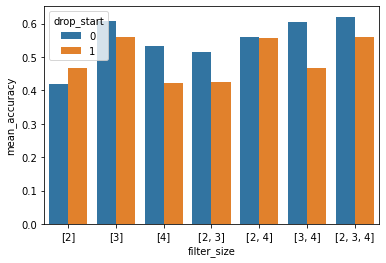

In [43]:
sns.barplot(x="filter_size", y="mean_accuracy", hue="drop_start", data=results_df)


Выведем лучшие параметры модели

In [44]:
results_df.iloc[[results_df['mean_accuracy'].idxmax()]]

,drop_start,filter_size,train_loss,val_loss,train_metric,val_metric,mean_accuracy
6,0,"[2, 3, 4]","[1.788469672203064, 1.6618895530700684, 1.5976...","[1.6487430334091187, 1.6717145442962646, 1.631...","[0.38211384, 0.43902442, 0.45238096, 0.4137931...","[0.47008547, 0.36752138, 0.4732143, 0.4, 0.422...",0.6205


Лосс достаточно большой, такой классификатор сложно назвать хорошим. 

Для улучшения мне кажется, в первую очередь стоит взять максимальный размер такой же, как и в статье: по отсеченным кускам длинные тексты предсказывать сложно. Также нужно сделать нормальные классы для обучения: например, увеличить их, или применять разные веса.